## Ejercicio 1. 

Clasificación de imágenes de radiografías de tórax (carpeta pneumonia)

El conjunto de datos contiene imágenes de pacientes con radiografías normales y con neumonía. Las imágenes de neumonía contienen tanto pacientes con neumonía “normal” como con neumonía por COVID19. Su objetivo es entrenar un modelo con el F-Score (o F-measure o F1) más alto en el conjunto de test.

* Entrene un modelo que obtenga al menos un f-score de 0.97 en test.

* El conjunto de datos está desbalanceado, así que deberá compensar para eso utilizando pesos por clase (parámetro class_weight del método fit). Utilice los pesos por clase para mejorar el F-score.

* Utilice un modelo pre-entrenado como MobileNet o ResNet18 para aumentar el desempeño.

* Diseñe una estrategia de aumentación de datos para aumentar el desempeño de las red. Estudie las imágenes de entrada y considere qué transformaciones pueden ser útiles para ese dominio.


In [ ]:
import numpy as np 
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:

!ls "gdrive/MyDrive"

 2019   2020  'Convoluciones 1D.ipynb'	 Pneumonia.ipynb


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Hay 2 directorios con los 2 subconjuntos de datos:  ['Tutorial Inicial.ipynb', 'train', '.ipynb_checkpoints', 'test']
La carpeta de cada subconjunto tiene dos subcarpetas: normal y pneumonia
Las imágenes tienen tamaño: (600, 600)


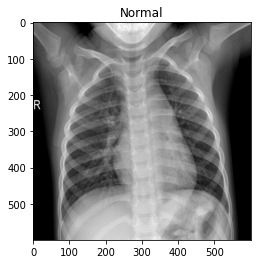

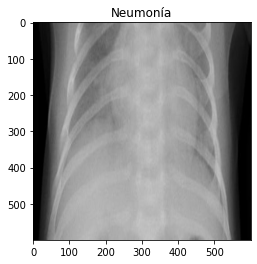

In [ ]:
from keras.preprocessing.image import load_img

from google.colab import drive
drive.mount('/content/gdrive/')
dataset_folderpath = "gdrive/MyDrive/2020/UBA - Redes neuronales 2020/Clase 11 y 12 (28nov y 1dic)/pneumonia/"
print("Hay 2 directorios con los 2 subconjuntos de datos: ",os.listdir(dataset_folderpath))
print("La carpeta de cada subconjunto tiene dos subcarpetas: normal y pneumonia")

train_folderpath = os.path.join(dataset_folderpath, "train")
test_folderpath = os.path.join(dataset_folderpath, "test")

img_name = '0385_normal.jpg'
image_path= f'normal/{img_name}'
img_normal = load_img(os.path.join(train_folderpath, image_path))

print(f"Las imágenes tienen tamaño: {img_normal.size}")

plt.imshow(img_normal)
plt.title("Normal")
plt.show()

img_name = '0192_bacteria.jpg'
image_path= f'pneumonia/{img_name}'
img_pneumonia = load_img(os.path.join(train_folderpath,image_path))
plt.imshow(img_pneumonia)
plt.title("Neumonía")
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


# Tamaño objetivo para escalar las imágenes. 
IMG_SIZE = 64
h,w,c = IMG_SIZE, IMG_SIZE, 3
batch_size = 32

# Preprocesamiento de cada subconjunto
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de los subconjuntos. Reciben un directorio, y 
# cada carpeta del directorio se interpreta como una clase distinta.
# En este caso como cada directorio tiene 3 subdirectorios, normal, covid y pneumonia,
# por ende, habrá tres clases.

train_generator = train_datagen.flow_from_directory(
    train_folderpath, # directorio de donde cargar las imagenes (train)
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_folderpath, # directorio de donde cargar las imagenes (val)
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='binary')



n_train = train_generator.samples
n_test = test_generator.samples
n_clases = train_generator.num_classes

print(f"Los conjuntos de train y test tienen {n_train}, y {n_test} ejemplos respectivamente.")
print(f"Los conjuntos de datos tienen {n_clases} clases.")

Found 5088 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Los conjuntos de train y test tienen 5088, y 256 ejemplos respectivamente.
Los conjuntos de datos tienen 2 clases.


In [113]:
from keras import backend as K
# Definición de las métricas F1, recall y precision utilizando Keras.

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*precision*recall/(precision+recall+K.epsilon())

In [114]:
from keras import Model
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Average, Input

x = Input(shape=(w, h, c))

def create_model(i):
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(i)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(16,activation="tanh")(x)
    result = Dense(1, activation='sigmoid')(x)
    return Model(inputs=[i], outputs=[result])
model = create_model(x)

In [116]:
from keras.optimizers import Adam

lr = 1e-4
epochs = 1


optim = Adam(lr=lr, decay=lr / epochs)
#val_steps = max(1, n_test // batch_size)
train_generator.reset()
test_generator.reset()
# Compilation with weighted metrics
model.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy", f1_m, precision_m, recall_m])
history = model.fit(train_generator,
                    steps_per_epoch=n_train // batch_size,
                    epochs=epochs,  validation_data= test_generator, shuffle=True
                    )

159/159 [==============================] - 31s 191ms/step - loss: 0.2405 - accuracy: 0.9171 - f1_m: 0.9458 - precision_m: 0.9278 - recall_m: 0.9677 - val_loss: 0.1967 - val_accuracy: 0.9570 - val_f1_m: 0.9572 - val_precision_m: 0.9565 - val_recall_m: 0.9604


In [117]:
from sklearn.metrics import classification_report
y_pred_prob =model.predict(train_generator, steps=n_train // batch_size)
y_pred = 1*(y_pred_prob > 0.5)
y_pred = y_pred.squeeze()
y_true = train_generator.classes


In [118]:

y_pred = np.squeeze(y_pred)
# A MANO
print("c0 samples",np.sum(y_true==0),"c1 samples",np.sum(y_true==1))
tp =  np.sum(np.logical_and(y_pred,y_true))
p = tp/ ((y_pred==1).sum())
r = tp/ ((y_true==1).sum())
print("p=",p,"r=",r,"f=",2*p*r/(p+r))

# sklearn
from sklearn.metrics import precision_recall_fscore_support

p,r,f,s=precision_recall_fscore_support(y_true,y_pred,average="binary")

print("p=",p,"r=",r,"f=",f)

# sklearn class report


pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))

c0 samples 1199 c1 samples 3889
p= 0.7618048268625394 r= 0.7467215222422217 f= 0.7541877678223609
p= 0.7618048268625394 r= 0.7467215222422217 f= 0.7541877678223609


0            1  accuracy    macro avg  weighted avg
precision     0.228056     0.761805  0.627948     0.494931      0.636026
recall        0.242702     0.746722  0.627948     0.494712      0.627948
f1-score      0.235152     0.754188  0.627948     0.494670      0.631876
support    1199.000000  3889.000000  0.627948  5088.000000   5088.000000

In [120]:
# Evaluar el accuracy del modelo en el conjunto entero de entrenamiento
print("*********** Conjunto de entrenamiento ***********")
train_generator.reset()
#_ = model.predict(train_generator, steps=n_train // batch_size)
scores = model.evaluate(train_generator, steps=n_train // batch_size)
for metric, score in zip(model.metrics_names, scores):
    print(f"{metric}: {score:.2f}")

print()
# Evaluar el accuracy del modelo en el conjunto entero de test
print("*********** Conjunto de test ***********")
test_generator.reset()
#_ = model.predict(test_generator, steps=n_test // batch_size)
scores = model.evaluate(test_generator, steps=n_test // batch_size)
for metric, score in zip(model.metrics_names, scores):
    print(f"{metric}: {score:.2f}")

*********** Conjunto de entrenamiento ***********
159/159 [==============================] - 23s 143ms/step - loss: 0.1966 - accuracy: 0.9401 - f1_m: 0.9599 - precision_m: 0.9702 - recall_m: 0.9510
loss: 0.20
accuracy: 0.94
f1_m: 0.96
precision_m: 0.97
recall_m: 0.95

*********** Conjunto de test ***********
8/8 [==============================] - 1s 157ms/step - loss: 0.1967 - accuracy: 0.9570 - f1_m: 0.9547 - precision_m: 0.9497 - recall_m: 0.9623
loss: 0.20
accuracy: 0.96
f1_m: 0.95
precision_m: 0.95
recall_m: 0.96
